# Indicator Dataset Analysis

In [1]:
# Import
import numpy as np
import pandas as pd 
from datetime import datetime
from datetime import timedelta
from IPython.display import HTML, display
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
import statistics
from msticpy.vis import mp_pandas_plot
from msticpy.vis.data_viewer import DataViewer
import math 

# Disable warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# Color palette
sns.set_palette("rocket")
colors = sns.set_palette("rocket")

## ThreatFox

In [2]:
# Remove all rows without a last_seen_utc
urlData = pd.read_csv('.\Data\Threat_Fox\\threat_fox_urls.csv',sep=',', skipinitialspace=True)
urlData = urlData.loc[urlData["last_seen_utc"].notna()]

ipData = pd.read_csv('.\Data\Threat_Fox\\threat_fox_ip.csv',sep=',', skipinitialspace=True)
ipData = ipData.loc[ipData["last_seen_utc"].notna()]

hashData = pd.read_csv('.\Data\Threat_Fox\\threat_fox_md5.csv',sep=',', skipinitialspace=True)
hashData = hashData.loc[hashData["last_seen_utc"].notna()]

In [3]:
# Remove all rows where the indicator is younger than one month
present = datetime.now()
past = timedelta(days=31)
month = present - past

urlData["last_seen_utc"] = urlData["last_seen_utc"].apply(lambda x: pd.to_datetime(x))
urlData["first_seen_utc"] = urlData["first_seen_utc"].apply(lambda x: pd.to_datetime(x))
urlData = urlData[urlData["last_seen_utc"] < month]
urlData = urlData[urlData["last_seen_utc"] != urlData["first_seen_utc"]]

ipData["last_seen_utc"] = ipData["last_seen_utc"].apply(lambda x: pd.to_datetime(x))
ipData["first_seen_utc"] = ipData["first_seen_utc"].apply(lambda x: pd.to_datetime(x))
ipData = ipData[ipData["last_seen_utc"] < month]
ipData = ipData[ipData["last_seen_utc"] != ipData["first_seen_utc"]]

hashData["last_seen_utc"] = hashData["last_seen_utc"].apply(lambda x: pd.to_datetime(x))
hashData["first_seen_utc"] = hashData["first_seen_utc"].apply(lambda x: pd.to_datetime(x))
hashData = hashData[hashData["last_seen_utc"] < month]
hashData = hashData[hashData["last_seen_utc"] != hashData["first_seen_utc"]]

In [4]:
# Calculate lifetime and delete negative values
urlData['lifetimeHours'] = (urlData["last_seen_utc"] - urlData["first_seen_utc"]) / pd.Timedelta(hours=1)
urlData = urlData[urlData['lifetimeHours'] >= 0].dropna()

ipData['lifetimeHours'] = (ipData["last_seen_utc"] - ipData["first_seen_utc"]) / pd.Timedelta(hours=1)
ipData = ipData[ipData['lifetimeHours'] >= 0].dropna()

hashData['lifetimeHours'] = (hashData["last_seen_utc"] - hashData["first_seen_utc"]) / pd.Timedelta(hours=1)
hashData = hashData[hashData['lifetimeHours'] >= 0].dropna()

In [5]:
fullData = pd.concat([urlData, hashData, ipData], axis=0)
print("Full: " + str(fullData.shape[0]) + " URL: " + str(urlData.shape[0]) + " IP: " + str(ipData.shape[0]) + " Hash: " + str(hashData.shape[0]))  

Full: 127448 URL: 87100 IP: 39308 Hash: 1040


In [6]:
fullData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127448 entries, 66 to 152673
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   first_seen_utc     127448 non-null  datetime64[ns]
 1   ioc_id             127448 non-null  float64       
 2   ioc_value          127448 non-null  object        
 3   ioc_type           127448 non-null  object        
 4   threat_type        127448 non-null  object        
 5   fk_malware         127448 non-null  object        
 6   malware_alias      127448 non-null  object        
 7   malware_printable  127448 non-null  object        
 8   last_seen_utc      127448 non-null  datetime64[ns]
 9   confidence_level   127448 non-null  float64       
 10  reference          127448 non-null  object        
 11  tags               127448 non-null  object        
 12  anonymous          127448 non-null  float64       
 13  reporter           127448 non-null  object 

In [7]:
print(fullData.malware_printable)

66         PrivateLoader
67         PrivateLoader
68         PrivateLoader
156                Coper
209        Lumma Stealer
               ...      
152669            Dridex
152670            Dridex
152671    Ficker Stealer
152672            Remcos
152673          SystemBC
Name: malware_printable, Length: 127448, dtype: object


In [8]:
# Display information
average = [["Mean Lifetime",timedelta(hours=fullData.loc[:, 'lifetimeHours'].mean())], 
           ["Mode Lifetime",timedelta(hours=float(fullData.loc[:, 'lifetimeHours'].mode()[0]))], 
           ["Median Lifetime",timedelta(hours=fullData.loc[:, 'lifetimeHours'].median())], 
           ["Shortest Lifetime",timedelta(hours=fullData.loc[:, 'lifetimeHours'].min())],
           ["Longest Lifetime",timedelta(hours=fullData.loc[:, 'lifetimeHours'].max()-fullData.loc[:, 'lifetimeHours'].min())],
           ["Range Lifetime",timedelta(hours=fullData.loc[:, 'lifetimeHours'].max())],
           ["Standard Error Lifetime",np.std(fullData.loc[:, 'lifetimeHours'], ddof=1) / np.sqrt(np.size(fullData.loc[:, 'lifetimeHours']))],
           ["Skewness Lifetime",skew(fullData.loc[:, 'lifetimeHours'], axis=0, bias=True)],
           ["Kurtosis Lifetime",kurtosis(fullData.loc[:, 'lifetimeHours'], axis=0, bias=True)]]

display(HTML(
   "<table><tr>{}</tr></table>".format(
       "</tr><tr>".join(
           "<td>{}</td>".format("</td><td>".join(str(_) for _ in row)) for row in average))
))

Mean Lifetime,"44 days, 18:13:09.314034"
Mode Lifetime,0:00:25
Median Lifetime,18:49:52
Shortest Lifetime,0:00:01
Longest Lifetime,"1364 days, 6:11:48"
Range Lifetime,"1364 days, 6:11:49"
Standard Error Lifetime,9.660617227173788
Skewness Lifetime,4.364400868970993
Kurtosis Lifetime,20.48417123895945


In [9]:
fullData["lifetimeDays"] = fullData["lifetimeHours"].apply(lambda x: math.ceil((x/24)))
fullData["lifetimeWeeks"] = fullData["lifetimeDays"].apply(lambda x: math.ceil((x/7)))

<Axes: xlabel='Lifetime in Weeks', ylabel='Count'>

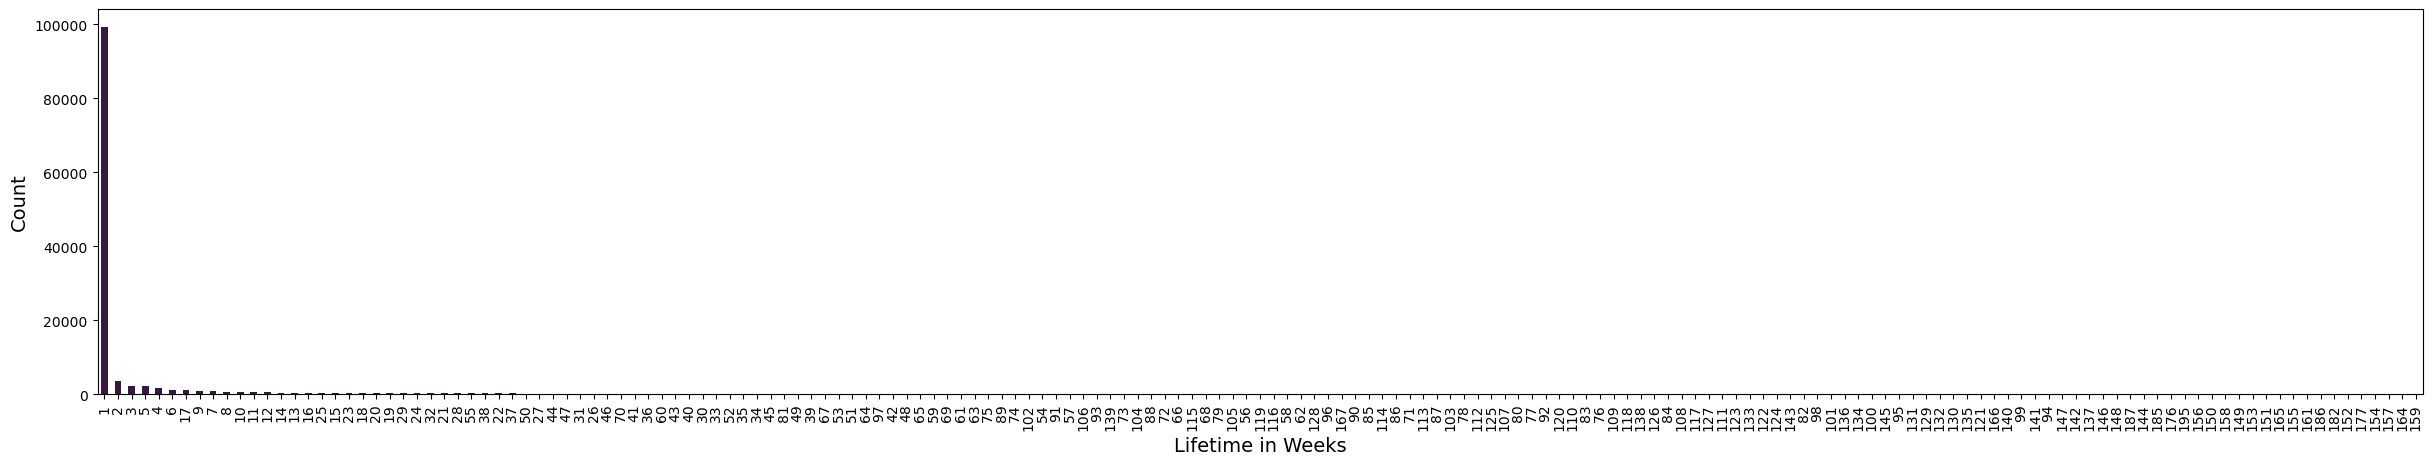

In [10]:
# Dispay as barplot
fig = plt.figure(figsize = (30, 5))
plt.xlabel("Lifetime in Weeks", fontsize=14)
plt.ylabel("Count", fontsize=14)
fullData["lifetimeWeeks"].value_counts().plot.bar()

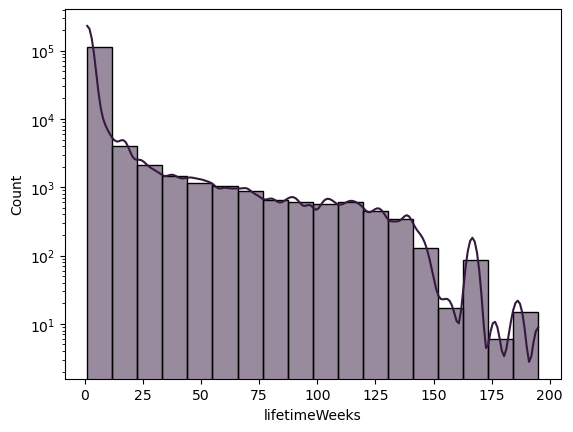

In [11]:
sns.histplot(fullData["lifetimeWeeks"], kde=True, log=True)
plt.savefig("threatfox_hist.svg",bbox_inches='tight')

<Axes: xlabel='confidence_level', ylabel='count'>

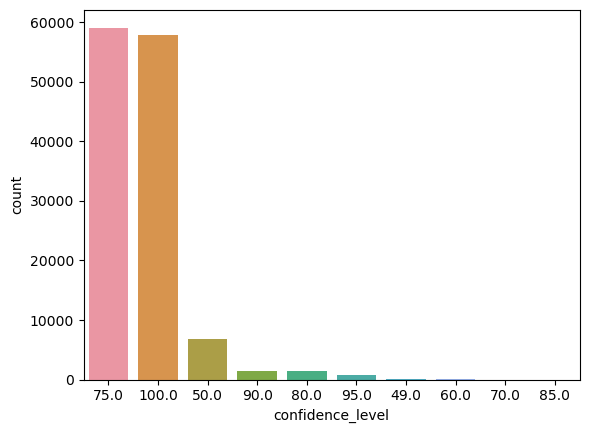

In [12]:
sns.countplot(x='confidence_level', data=fullData, order=fullData.confidence_level.value_counts().iloc[:10].index)
#plt.savefig("conf_dis.svg",bbox_inches='tight')

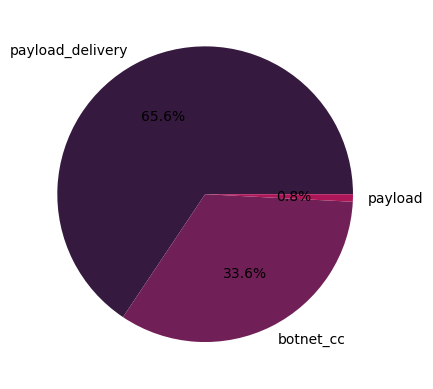

In [13]:
threat_count = fullData["threat_type"].value_counts()
plt.pie(threat_count.values, labels = threat_count.index, colors = colors, autopct='%1.1f%%')
plt.show()
#plt.savefig("conf_dis.svg",bbox_inches='tight')

In [14]:
fullData["fk_malware"].value_counts()

win.qakbot             83801
win.cobalt_strike       9216
win.redline_stealer     4808
unknown                 2889
win.emotet              2661
                       ...  
win.sidewinder             1
elf.plead                  1
win.winnti                 1
win.machete                1
win.buer                   1
Name: fk_malware, Length: 242, dtype: int64

## URL APT Phishing Indicator Dataset

In [15]:
customData = pd.read_csv(".\Data\\Phishing\VT_Submissions_Metadata.csv", sep=",", encoding='windows-1252')
# Separat sightings
customData["sightings"] = customData["sightings"].str.split("#")

# Remove all rows where the indicator is younger than 1 month
present = datetime.now()
past = timedelta(days=31)
year = present - past

customData["Last Submission"] = customData["Last Submission"].apply(lambda x: pd.to_datetime(x))
customData["First Submission"] = customData["First Submission"].apply(lambda x: pd.to_datetime(x))
customData["lifetimeInHours"] = (customData["Last Submission"] - customData["First Submission"]) / pd.Timedelta(hours=1)
customData = customData[customData["Last Submission"] < year]
customData = customData[customData["Last Submission"] != customData["First Submission"]]
customData = customData[customData['lifetimeInHours'] >= 0].dropna()
customData = customData[customData['Malicious'] != 0]

In [16]:
customData.head()

,Unnamed: 0,Indicator,ID,Type,Threat Name,TLD,Last Submission,First Submission,Malicious,Harmless,sightings,lifetimeInHours
0,0,calendar-ua.firstcloudit.com,3744f508ffae357561e31e0a57d33336d82f71da7674cb...,url,['Mal/HTMLGen-A'],com,2024-10-06 01:45:00,2024-02-27 06:52:40,6,62,"[2024-10-06 01:45:00, 2024-10-05 23:25:43, 202...",5322.872222
1,0,calendarua.firstcloudit.com,0a8ce89569d558d9fefcb4ab46c3a276fb59716a93cf44...,url,['Mal/HTMLGen-A'],com,2024-10-05 23:26:13,2024-02-27 06:52:44,5,63,"[2024-10-05 23:26:13, 2024-08-30 04:38:24, 202...",5320.558056
2,0,dls-gov.firstcloudit.com,70ea1dc461e51cd37480afb52fd758218bfcedd95f4063...,url,[],com,2024-09-29 16:57:38,2024-02-27 06:52:37,7,62,"[2024-09-29 16:57:38, 2024-08-30 04:38:25, 202...",5170.083611
3,0,e-gov-am.firstcloudit.com,e24501b97c978979be2c26ac0533cffec5eb7151595335...,url,[],com,2024-09-29 16:57:57,2023-11-27 18:12:56,6,61,"[2024-09-29 16:57:57, 2024-08-30 04:38:25, 202...",7366.750278
4,0,e-gov.firstcloudit.com,af5fda8a5f3a352efb4d1dd69c3edc3e740bd59375099b...,url,[],com,2024-09-29 16:57:39,2024-02-27 06:52:43,6,61,"[2024-09-29 16:57:39, 2024-08-30 04:38:25, 202...",5170.082222


In [17]:
customData.shape[0]

299

In [18]:
customData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 361
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        299 non-null    int64         
 1   Indicator         299 non-null    object        
 2   ID                299 non-null    object        
 3   Type              299 non-null    object        
 4   Threat Name       299 non-null    object        
 5   TLD               299 non-null    object        
 6   Last Submission   299 non-null    datetime64[ns]
 7   First Submission  299 non-null    datetime64[ns]
 8   Malicious         299 non-null    int64         
 9   Harmless          299 non-null    int64         
 10  sightings         299 non-null    object        
 11  lifetimeInHours   299 non-null    float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 30.4+ KB


In [19]:
# Display information
average = [["Mean Lifetime",timedelta(hours=customData.loc[:, 'lifetimeInHours'].mean())], 
           ["Mode Lifetime",timedelta(hours=float(customData.loc[:, 'lifetimeInHours'].mode()[0]))], 
           ["Median Lifetime",timedelta(hours=customData.loc[:, 'lifetimeInHours'].median())], 
           ["Shortest Lifetime",timedelta(hours=customData.loc[:, 'lifetimeInHours'].min())],
           ["Longest Lifetime",timedelta(hours=customData.loc[:, 'lifetimeInHours'].max()-customData.loc[:, 'lifetimeInHours'].min())],
           ["Range Lifetime",timedelta(hours=customData.loc[:, 'lifetimeInHours'].max())],
           ["Standard Error Lifetime",np.std(customData.loc[:, 'lifetimeInHours'], ddof=1) / np.sqrt(np.size(customData.loc[:, 'lifetimeInHours']))],
           ["Skewness Lifetime",skew(customData.loc[:, 'lifetimeInHours'], axis=0, bias=True)],
           ["Kurtosis Lifetime",kurtosis(customData.loc[:, 'lifetimeInHours'], axis=0, bias=True)]]

display(HTML(
   "<table><tr>{}</tr></table>".format(
       "</tr><tr>".join(
           "<td>{}</td>".format("</td><td>".join(str(_) for _ in row)) for row in average))
))

Mean Lifetime,"1308 days, 8:38:52.959866"
Mode Lifetime,"1696 days, 3:56:54"
Median Lifetime,"1269 days, 8:32:23"
Shortest Lifetime,8:44:37
Longest Lifetime,"3267 days, 12:08:24"
Range Lifetime,"3267 days, 20:53:01"
Standard Error Lifetime,1242.1065591183083
Skewness Lifetime,0.18899289391211416
Kurtosis Lifetime,-1.005217246151451


In [20]:
customData["lifetimeDays"] = customData["lifetimeInHours"].apply(lambda x: math.ceil((x/24)))
customData["lifetimeWeeks"] = customData["lifetimeInHours"].apply(lambda x: math.ceil((x/7)))

<Axes: xlabel='Lifetime in Weeks', ylabel='Count'>

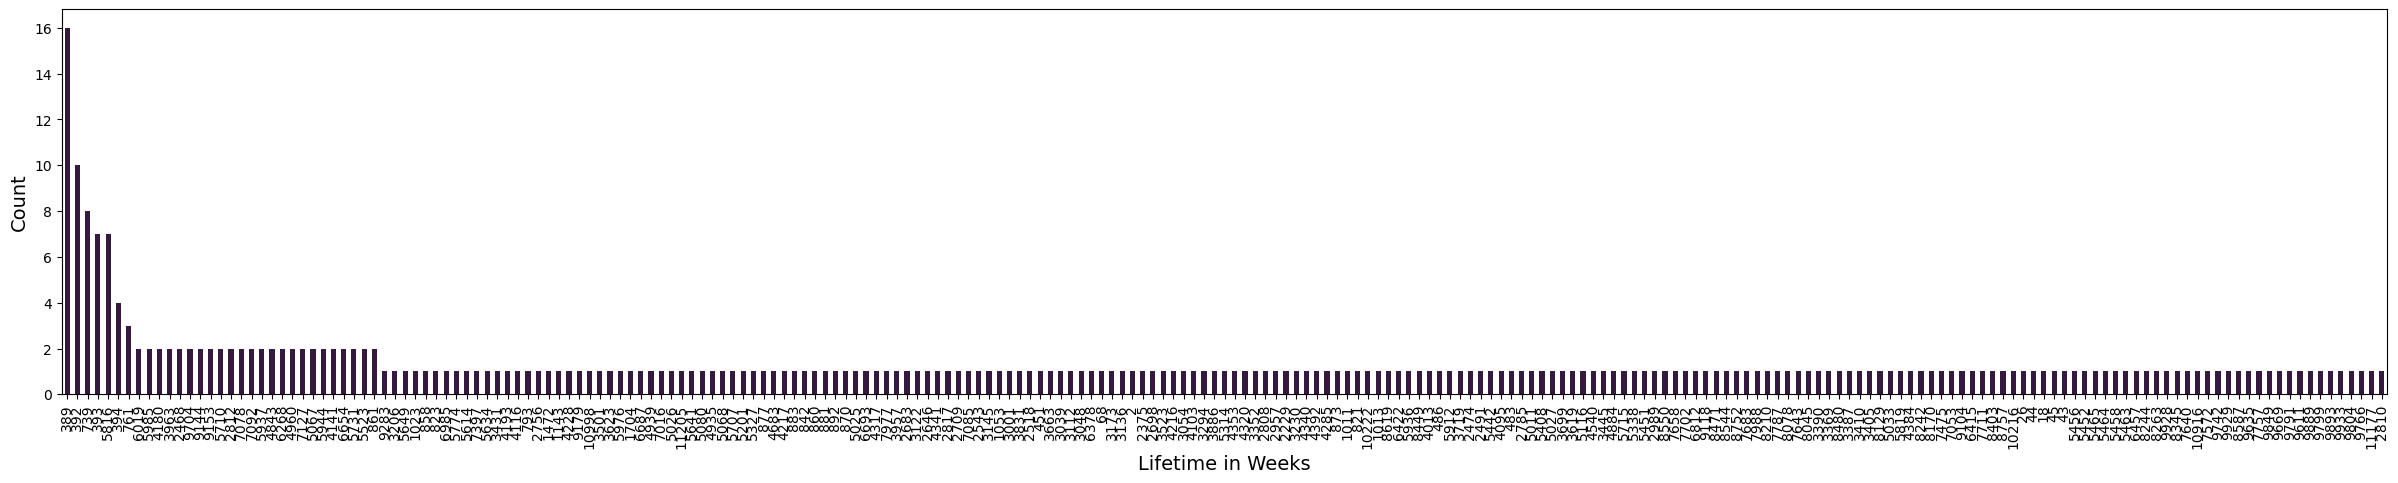

In [21]:
# Dispay as barplot
fig = plt.figure(figsize = (30, 5))
plt.xlabel("Lifetime in Weeks", fontsize=14)
plt.ylabel("Count", fontsize=14)
customData["lifetimeWeeks"].value_counts().plot.bar()

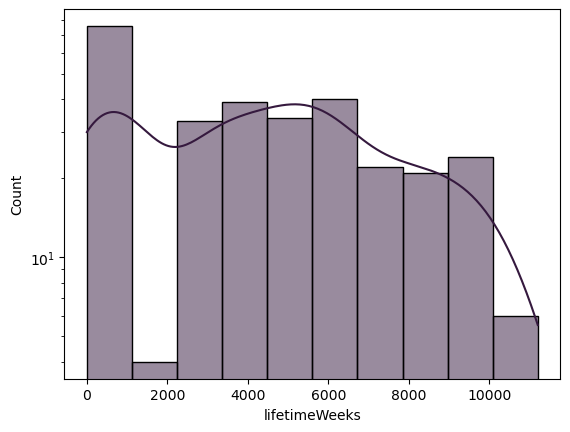

In [22]:
sns.histplot(customData["lifetimeWeeks"], kde=True, log=True)
plt.savefig("vt_hist.svg",bbox_inches='tight')

<Axes: xlabel='Malicious', ylabel='count'>

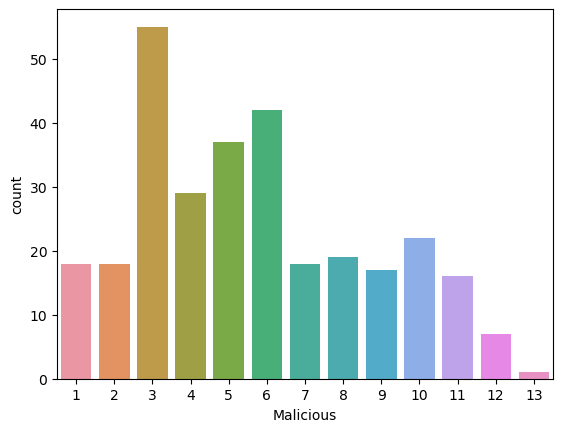

In [23]:
sns.countplot(x='Malicious', data=customData)

<Axes: xlabel='Harmless', ylabel='count'>

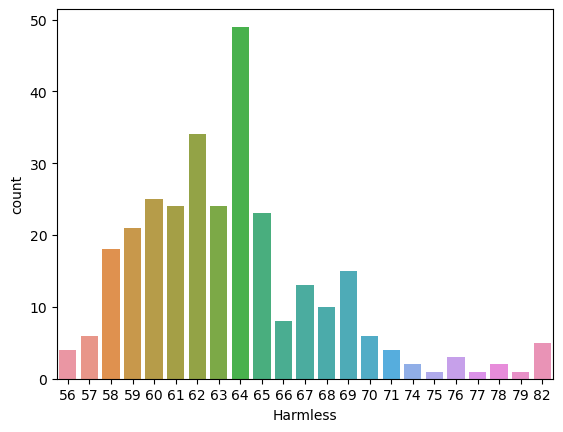

In [24]:
sns.countplot(x='Harmless', data=customData)

<Axes: xlabel='TLD', ylabel='count'>

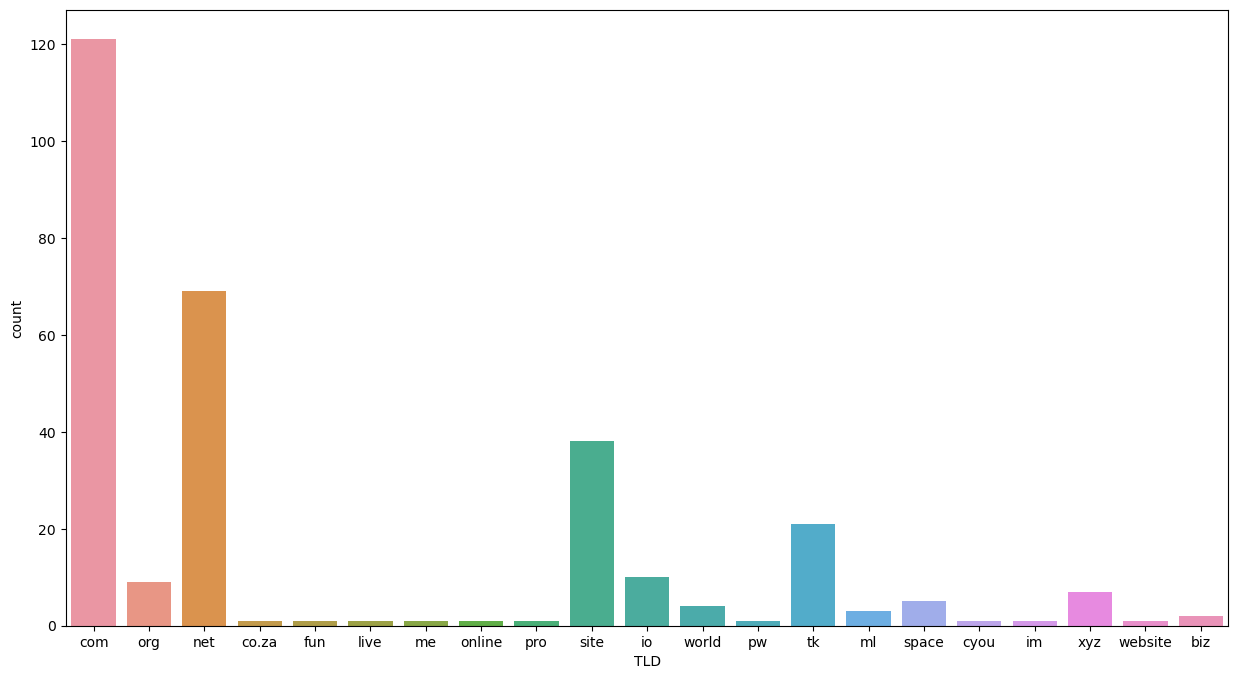

In [25]:
plt.figure(figsize=(15,8))
sns.countplot(x='TLD', data=customData)

In [26]:
customData.TLD.value_counts()

com        121
net         69
site        38
tk          21
io          10
org          9
xyz          7
space        5
world        4
ml           3
biz          2
live         1
me           1
online       1
pro          1
fun          1
pw           1
co.za        1
cyou         1
im           1
website      1
Name: TLD, dtype: int64

In [27]:
customData["Threat Name"].value_counts()

[]                                   139
['Mal/HTMLGen-A']                    124
['C2/Generic-A']                      35
['C2/Generic-A', 'Mal/HTMLGen-A']      1
Name: Threat Name, dtype: int64